## Model setup XBeach 2D

Setup a 2D XBeach model with the Python toolbox 

In [14]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(os.path.abspath(os.path.join('..', '..', 'xbeach-toolbox')))

Import the toolbox.

In [15]:
## import specific tools from xbTools
from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend, lateral_extend
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.general import wave_functions, visualize_mesh

### Data
Load and plot the bathymetry data

Text(0.5, 0.5, 'y [m]')

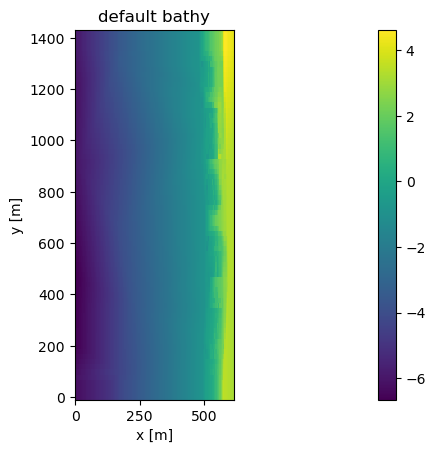

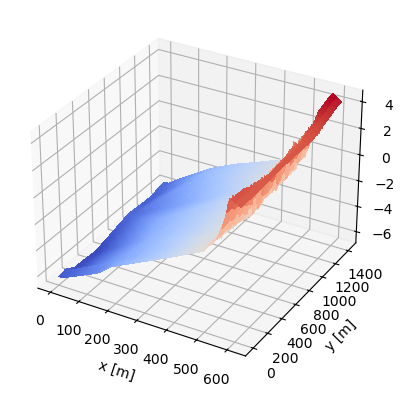

In [16]:
## load data
bathy = np.loadtxt('..//examples//data//input//bathy.dep')

## set bathy grid
nx = 124
ny = 72
dx = 5
dy = 20

x = np.linspace(0,(nx-1)*dx,nx)
y = np.linspace(0,(ny-1)*dy,ny)

X, Y = np.meshgrid(x,y)

## plot
plt.figure()
plt.pcolor(x,y,bathy)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('default bathy')
plt.axis('scaled')

fig     = plt.figure()
ax = fig.add_subplot(projection='3d')
surf    = ax.plot_surface(X, Y, bathy, cmap=cm.coolwarm,  linewidth=0, antialiased=False)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### Create x-grid
Create spatially varying x-grid resolution.

Note that the following settings can be specified:

`xgrid(x,z,
          ppwl=20,
          dxmin=5,
          dxmax=np.inf,
          vardx=1,
          wl = 0,
          eps = 0.01,
          Tm = 8,
          xdry=None,
          zdry=None,
          dxdry = None,
          depthfac = 2,
          maxfac = 1.15,
          nonh = False)`

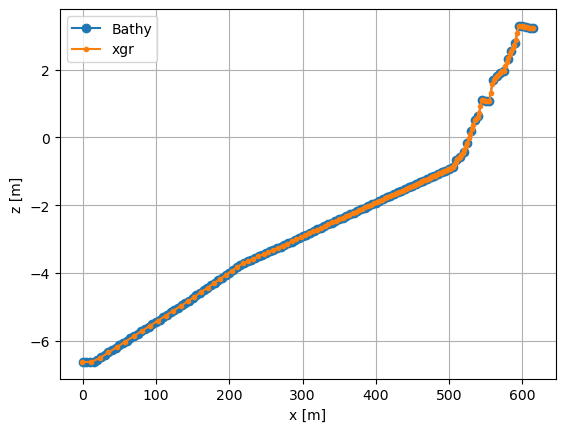

In [17]:
xgr,zgr = xgrid(x, bathy[20,:],dxmin=2)


plt.figure()
plt.plot(x,bathy[20,:],'-o')
plt.plot(xgr,zgr,'.-')
plt.legend(['Bathy','xgr'])
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.grid('on')

### Create y-grid
Create spatially varying y-grid resolution.

ygrid has the following default settings:

`ygrid(y,
           dymin = 5,
           dymax = 20,
           area_type='center',
           maxerror = 0.05,
           transition_distance = -0.1,
           area_size = 0.4):`

Enable optimization of transition distance
Area type center
Transition 142.0


c:\ERDC\xbeach-toolbox\xbTools\grid\creation.py:350: RuntimeWarning: overflow encountered in power
  Lj[1] = cell1 * np.sum(np.power(fj[1],np.arange(1,ni+1,1)) )
c:\ERDC\xbeach-toolbox\xbTools\grid\creation.py:351: RuntimeWarning: overflow encountered in scalar multiply
  Lj[2] = cell1 * np.sum(np.power(np.mean(fj),np.arange(1,ni+1,1)) )
c:\ERDC\xbeach-toolbox\xbTools\grid\creation.py:351: RuntimeWarning: overflow encountered in power
  Lj[2] = cell1 * np.sum(np.power(np.mean(fj),np.arange(1,ni+1,1)) )
c:\ERDC\xbeach-toolbox\xbTools\grid\creation.py:341: RuntimeWarning: overflow encountered in scalar multiply
  fj[1] = 1.1 * fj[1]


Text(0, 0.5, 'dy [m]')

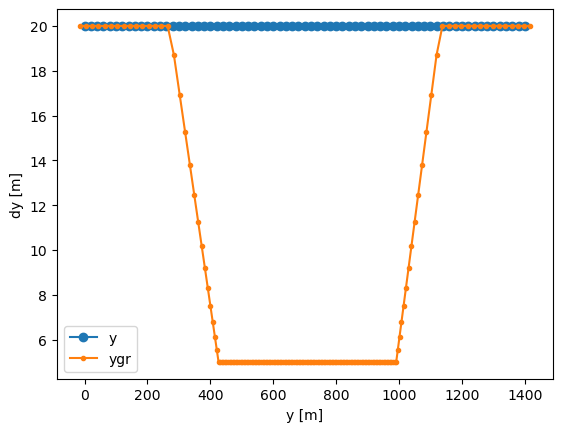

In [18]:
ygr = ygrid(y)

plt.figure()
plt.plot(y[:-1],np.diff(y),'-o')
plt.plot(ygr[:-1],np.diff(ygr),'.-')
plt.legend(['y','ygr'])
plt.xlabel('y [m]')
plt.ylabel('dy [m]')

### Interpolate
Interpolate data to new grid

C:\Users\johnm\AppData\Local\Temp\ipykernel_2164\2343223386.py:1: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, bathy, kind='linear')
C:\Users\johnm\AppData\Local\Temp\ipykernel_2164\2343223386.py:3: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` ins

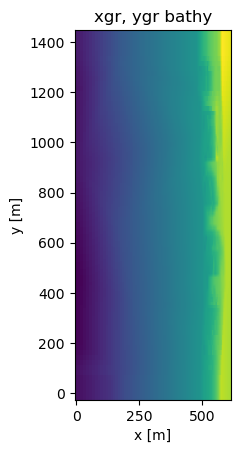

In [19]:
f = interpolate.interp2d(x, y, bathy, kind='linear')

zgr = f(xgr,ygr)

plt.figure()
plt.pcolor(xgr,ygr,zgr)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('scaled')
plt.title('xgr, ygr bathy')

xgr, ygr = np.meshgrid(xgr,ygr)

### Seaward extend
Extend the grid to the required offshore depth. In this case 20 m with a artifial slope of 1/20.

If desired the function `offshore_depth` can also be used to determine the required offshore water depth.

Artificial slope of 1:50
Hm0,shoal = 8.5714772110995
d start = 28.572742030201947
Hm0,shoal/d profile = 1.3810990753466756
Hm0,shoal/d slope = 0.29998791162707733
n profile = 0.963619723035612
n slope = 0.8429281423665087


Text(0, 0.5, 'z [m]')

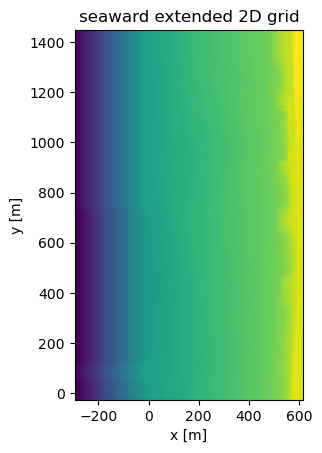

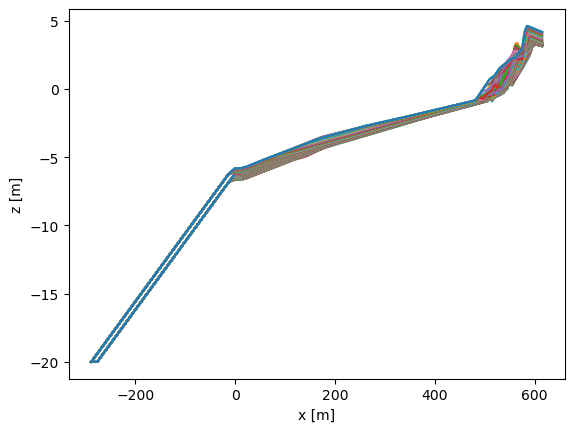

In [20]:
d_start, slope, Hm0_shoal = wave_functions.offshore_depth(Hm0=9, Tp=15, depth_offshore_profile=abs(bathy[0,0]), depth_boundary_conditions=20)

xgr, ygr, zgr = seaward_extend(xgr,ygr,zgr,slope=1/20,depth=-20)

plt.figure()
plt.pcolor(xgr,ygr,zgr)
plt.axis('scaled')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('seaward extended 2D grid')

plt.figure()
plt.plot(xgr[:,:].T,zgr[:,:].T)
plt.xlabel('x [m]')
plt.ylabel('z [m]')

### Lateral extend
Extend the grid lateral with 5 rows

Text(0.5, 1.0, 'lateral extended 2D grid')

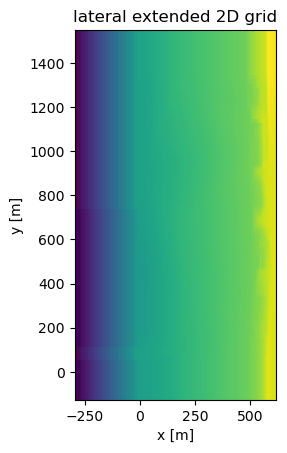

In [21]:
xgr,ygr,zgr = lateral_extend(xgr,ygr,zgr,n=5)

plt.figure()
plt.pcolor(xgr,ygr,zgr)
plt.axis('scaled')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('lateral extended 2D grid')

### Create model setup
Create the model setup class

No wavemodel defined. Wavemodel is set to Surfbeat


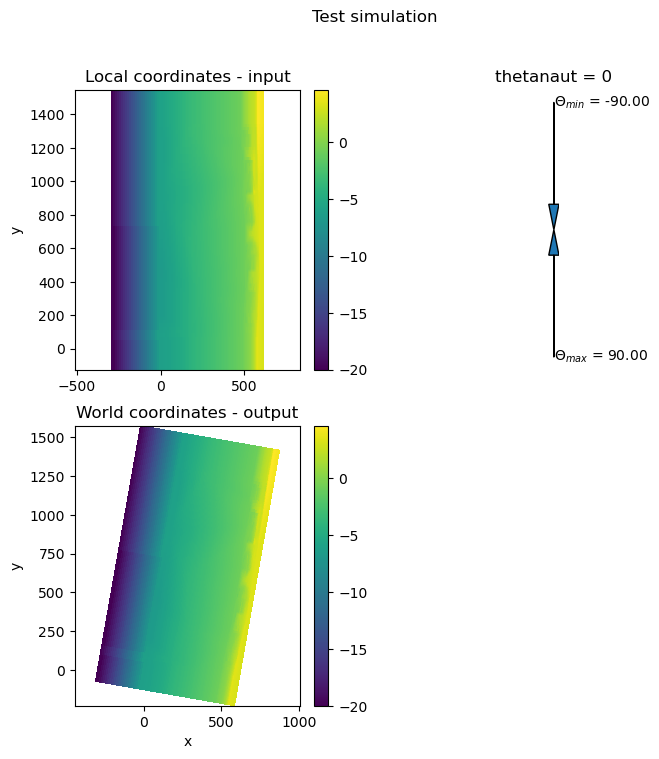

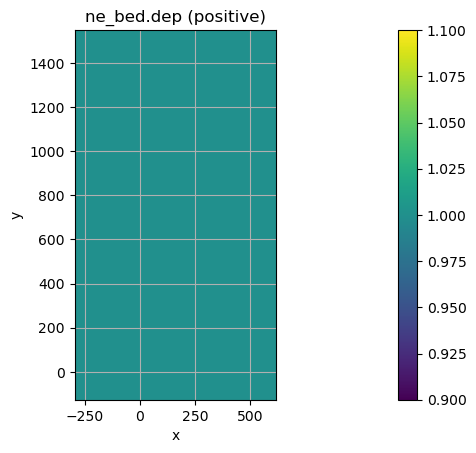

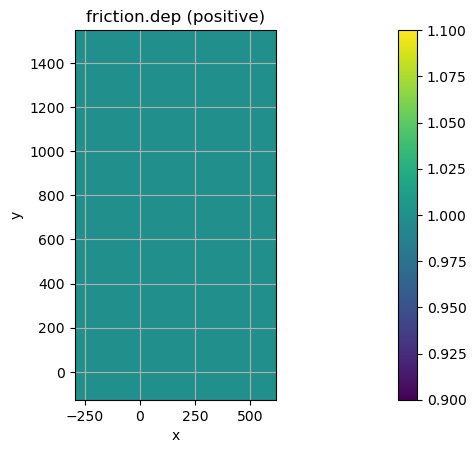

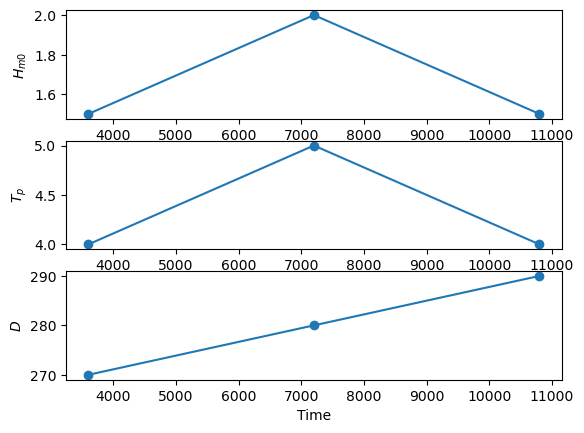

In [22]:
xb_setup = XBeachModelSetup('Test simulation')

xb_setup.set_grid(xgr, ygr, zgr, posdwn=-1, alfa=10)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

xb_setup.set_waves('jonstable',    {'Hm0'       :   [1.5, 2, 1.5],
                                    'Tp'        :   [4, 5, 4],
                                    'gammajsp'  :   [3.3, 3.3, 3.3], 
                                    's'         :   [20, 20, 20],
                                    'mainang'   :   [270, 280, 290],
                                    'duration'  :   [3600, 3600, 3600],
                                    'dtbc'      :   [1,1,1]})

xb_setup.set_params({'Wavemodel'    :   'surfbeat',
                     'morphology'   :   0,
                     'bedfriccoef'   :   0.01,
                     'tstop'        :   3600,
                     'zs0'          :   0,
                     'nglobalvar'   :   ['zb', 'zs', 'H'],
                     'npointvar'    :   ['zs', 'H'],
                     'nmeanvar'     :   ['zb'],
                     'npoints'      :   ['1 0', '6 0', '10 0', '12 0']})

sim_path = os.path.join('xb-2D')
if not os.path.exists(sim_path):
    os.mkdir(sim_path)
xb_setup.write_model(os.path.join(sim_path))

### Write grid to shapefile
Create a shapefile.

In [23]:
visualize_mesh.write_mesh_to_shp(xgr, ygr, os.path.join('xb-2D','shape/grid.shp'),0)

xb-2D\shape/grid.shp is saved


C:\Users\johnm\AppData\Local\Temp\ipykernel_2164\1464800397.py:1: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  visualize_mesh.write_mesh_to_shp(xgr, ygr, os.path.join('xb-2D','shape/grid.shp'),0)
